## TDEs with LSST

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.plots as plots

# open database use OpsimDatabase
opsdb = db.OpsimDatabase('baseline2018a.db')
# output
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)


## write a metric to get data of any column

In [2]:
class getDataMetric(metrics.BaseMetric):
    """
    returns required data 
    """
    
    def __init__(self, colname=['expMJD', 'airmass'], **kwargs):
        self.colname = colname
        super().__init__(col=colname, metricDtype='object', **kwargs)
        
        
    def run(self, dataSlice, slicePoint=None):
        
        # return dataSlice directly
        result = dataSlice
        
        return result
   

In [33]:
metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldId', 'skyBrightness', 'filter'])
slicer = slicers.UniSlicer()
#slicer = slicers.HealpixSlicer(nside=16)
sqlconstraint = 'night<20'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)


Querying database SummaryAllProps with constraint night<20 for columns ['night', 'fieldDec', 'fieldRA', 'observationStartMJD', 'filter', 'skyBrightness']
Found 15051 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<20" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/db/resultsDb.py:290: UserWarning: Warning! Cannot save non-conforming summary statistic.
  warnings.warn('Warning! Cannot save non-conforming summary statistic.')


In [34]:
data = Sky.metricValues.data

dataframe = pd.DataFrame(data[0])

In [35]:
np.unique(dataframe['filter'])

array(['g', 'i', 'r', 'y', 'z'], dtype=object)

## get light curve of TDEs from txt

In [44]:
tde_csv = pd.read_csv('tdelc.txt')  # downloaded from http://tde.space
tde_csv.head(5)

,event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
0,PTF09ge,54910.453,22.0011,NaN,T,g,PTF 48-Inch,NaN,2014ApJ...793...38A
1,PTF09ge,54917.259,21.3492,NaN,T,g,PTF 48-Inch,NaN,2014ApJ...793...38A
2,PTF09ge,54918.404,21.5973,NaN,T,g,PTF 48-Inch,NaN,2014ApJ...793...38A
3,PTF09ge,54921.240,21.3838,NaN,T,g,PTF 48-Inch,NaN,2014ApJ...793...38A
4,PTF09ge,54921.316,21.5319,NaN,T,g,PTF 48-Inch,NaN,2014ApJ...793...38A


In [58]:
del tde_csv['upperlimit'] 

In [65]:
tdelc = tde_csv.dropna()
tdelc.head()

,time,magnitude,e_magnitude,band
5,54958.174,19.1773,0.048395,r
6,54958.231,19.2245,0.051890,r
7,54958.308,19.2480,0.050447,r
8,54958.368,19.1125,0.049466,r
9,54958.415,19.1886,0.043521,r


In [67]:
tdelc.to_csv('tdelc.csv', index=False)

In [69]:
tdelc = pd.read_csv('tdelc.csv')
tdelc.head()

,time,magnitude,e_magnitude,band
0,54958.174,19.1773,0.048395,r
1,54958.231,19.2245,0.051890,r
2,54958.308,19.2480,0.050447,r
3,54958.368,19.1125,0.049466,r
4,54958.415,19.1886,0.043521,r


In [84]:
np.unique(tdelc['band'])

array(['g', 'i', 'r'], dtype=object)

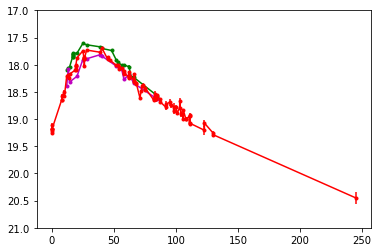

In [114]:
def plotlc(tdelc):
    colors = {'g':'g', 'i':'m', 'r':'r'}

    for f in np.unique(tdelc['band']):
        time = tdelc.loc[tdelc['band']==f]['phase']
        mag = tdelc.loc[tdelc['band']==f]['magnitude']
        magerr = tdelc.loc[tdelc['band']==f]['e_magnitude']

        #plt.plot(time, mag, color=colors[f], marker='.')
        plt.errorbar(time, mag, yerr=magerr, color=colors[f], marker='.')
        plt.ylim([21, 17])
        
plotlc(tdelc)

In [97]:
phase = tdelc['time'] - np.min(tdelc['time'])

In [100]:
phase_col = pd.DataFrame({'phase':phase})
phase_col.head()

,phase
0,0.000
1,0.057
2,0.134
3,0.194
4,0.241


In [108]:
tdelc['phase'] = phase_col

In [110]:
tdelc.head()

,time,magnitude,e_magnitude,band,phase
0,54958.174,19.1773,0.048395,r,0.000
1,54958.231,19.2245,0.051890,r,0.057
2,54958.308,19.2480,0.050447,r,0.134
3,54958.368,19.1125,0.049466,r,0.194
4,54958.415,19.1886,0.043521,r,0.241


In [111]:
del tdelc['time']

In [117]:
cols = ['phase', 'magnitude', 'e_magnitude', 'band']
tdelc = tdelc[cols]
tdelc.head()

,phase,magnitude,e_magnitude,band
0,0.000,19.1773,0.048395,r
1,0.057,19.2245,0.051890,r
2,0.134,19.2480,0.050447,r
3,0.194,19.1125,0.049466,r
4,0.241,19.1886,0.043521,r


In [140]:
tdelc_order = tdelc.sort_values(['band', 'phase'])

In [141]:
# write prepared data to file
tdelc_order.to_csv('tde.dat', index=False, header=False, sep=' ')

## evaluate detection of TDEs from opsim database 

In [2]:

class TransientAsciiMetricNew(metrics.BaseMetric):
    """Based on the transientMetric, but uses an ascii input file and provides option to write out lightcurve.

    Calculate what fraction of the transients would be detected. Best paired with a spatial slicer.
    The lightcurve in input is an ascii file per photometric band so that different lightcurve
    shapes can be implemented.

    Parameters
    ----------
    asciifile : str
        The ascii file containing the inputs for the lightcurve (per filter):
        File should contain three columns - ['ph', 'mag', 'flt'] -
        of phase/epoch (in days), magnitude (in a particular filter), and filter.
    surveyDuration : float, optional
        Length of survey (years).
        Default 10 or maximum of timespan of observations.
    surveyStart : float, optional
        MJD for the survey start date.
        Default None (uses the time of the first observation at each pointing).
    detectSNR : dict, optional
        An observation will be counted toward the discovery criteria if the light curve SNR
        is higher than detectSNR (specified per bandpass).
        Values must be provided for each filter which should be considered in the lightcurve.
        Default is {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
    nPreT : int, optional
        Number of observations (in any filter(s)) to demand before preT,
        before saying a transient has been detected.
        Default 0.
    preT : float, optional
        The time by which nPreT detections are required (in days).
        Default 5.0.
    nFilters : int, optional
        Number of filters that need to be observed for an object to be counted as detected.
        Default 1. (if nPerLC is 0, then this will be reset to 0).
    #-------------------------------------------
    nFiltersPreT: Number of filters required to be observed before preT

    #-------------------------------------------

    filterT : float, optional
        The time within which observations in at least nFilters are required (in days).
        Default None (no time constraint).
    nPerLC : int, optional
        Number of sections of the light curve that must be sampled above the detectSNR theshold
        for the light curve to be counted.
        For example, nPerLC = 2 means a light curve  is only considered detected if there
        is at least 1 observation in the first half of the LC, and at least one in the second half of the LC.
        nPerLC = 4 means each quarter of the light curve must be detected to count.
        Default 1.
    nPhaseCheck : int, optional
        Sets the number of phases that should be checked.
        One can imagine pathological cadences where many objects pass the detection criteria,
        but would not if the observations were offset by a phase-shift.
        Default 1.
    peakOffset : float, optional
        Add peakOffset to the magnitudes in the ascii file. Default 0.
    dataout : bool, optional
        If True, metric returns full lightcurve at each point. Note that this will potentially
        create a very large metric output data file.
        If False, metric returns the number of transients detected.
    """
    def __init__(self, asciifile, metricName='TransientAsciiMetricNew', mjdCol='expMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter',
                 surveyDuration=10., surveyStart=None,
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                 nPreT=0, preT=5.0, nFilters=1, nFiltersPreT=1, filterT=None, nPerLC=1, nPhaseCheck=1,
                 peakOffset=0.0, dataout=False, **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.dataout = dataout

        # if you want to get the light curve in output you need to define the metricDtype as object
        if self.dataout:
            super(TransientAsciiMetricNew, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        else:
            super(TransientAsciiMetricNew, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       units='Fraction Detected', metricName=metricName,
                                                       **kwargs)
        self.surveyDuration = surveyDuration
        self.surveyStart = surveyStart
        self.detectSNR = detectSNR
        self.nPreT = nPreT
        self.preT = preT
        self.nFilters = nFilters

        self.nFiltersPreT = nFiltersPreT

        self.filterT = filterT

        self.peakOffset = peakOffset
        self.nPerLC = nPerLC
        if self.nPerLC == 0:
            self.nFilters = 0
        self.nPhaseCheck = nPhaseCheck
        # Read ascii lightcurve template here. It doesn't change per slicePoint.
        self.read_lightCurve(asciifile)

    def read_lightCurve(self, asciifile):
        """Reads in an ascii file, 3 columns: epoch, magnitude, filter

        Returns
        -------
        numpy.ndarray
            The data read from the ascii text file, in a numpy structured array with columns
            'ph' (phase / epoch, in days), 'mag' (magnitude), 'flt' (filter for the magnitude).
        """
        if not os.path.isfile(asciifile):
            raise IOError('Could not find lightcurve ascii file %s' % (asciifile))
        self.lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])
        self.transDuration = self.lcv_template['ph'].max() - self.lcv_template['ph'].min()

    def make_lightCurve(self, time, filters):
        """Turn lightcurve definition into magnitudes at a series of times.

        Parameters
        ----------
        time : numpy.ndarray
            The times of the observations.
        filters : numpy.ndarray
            The filters of the observations.

        Returns
        -------
        numpy.ndarray
             The magnitudes of the object at the times and in the filters of the observations.
        """
        lcMags = np.zeros(time.size, dtype=float)
        for key in set(self.lcv_template['flt']):
            fMatch_ascii = np.where(np.array(self.lcv_template['flt']) == key)[0]
            # Interpolate the lightcurve template to the times of the observations, in this filter.
            lc_ascii_filter = np.interp(time, np.array(self.lcv_template['ph'], float)[fMatch_ascii],
                                        np.array(self.lcv_template['mag'], float)[fMatch_ascii])
            lcMags[filters == key.decode("utf-8")] = lc_ascii_filter[filters == key.decode("utf-8")]
        lcMags += self.peakOffset
        return lcMags

    def run(self, dataSlice, slicePoint=None):
        """"Calculate the detectability of a transient with the specified lightcurve.

        If self.dataout is True, then returns the full lightcurve for each object instead of the total
        number of transients that are detected.

        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.

        Returns
        -------
        float or dict
            The total number of transients that could be detected. (if dataout is False)
            A dictionary with arrays of 'lcNumber', 'lcMag', 'detected', 'time', 'detectThresh', 'filter'
        """

        # Sort the entire dataSlice in order of time.
        dataSlice.sort(order=self.mjdCol)

        # Check that surveyDuration is not larger than the time of observations we obtained.
        # (if it is, then the nTransMax will not be accurate).
        tSpan = (dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()) / 365.25
        surveyDuration = np.max([tSpan, self.surveyDuration])

        if self.surveyStart is None:
            surveyStart = dataSlice[self.mjdCol].min()
        else:
            surveyStart = self.surveyStart

        # Set up the starting times for each of the back-to-back sets of transients.
        tshifts = np.arange(self.nPhaseCheck) * self.transDuration / float(self.nPhaseCheck)
        # Total number of transient which have reached detection threshholds.
        nDetected = 0
        # Total number of transients which could possibly be detected,
        # given survey duration and transient duration.
        nTransMax = 0
        # Set this, in case surveyStart was set to be much earlier than this data (so we start counting at 0).
        lcNumberStart = -1 * np.floor((dataSlice[self.mjdCol].min() - surveyStart) / self.transDuration)

        # Consider each different 'phase shift' separately.
        # We then just have a series of lightcurves, taking place back-to-back.
        for tshift in tshifts:
            # Update the maximum possible transients that could have been observed during surveyDuration.
            nTransMax += np.ceil(surveyDuration / (self.transDuration / 365.25))
            # Calculate the time/epoch for each lightcurve.
            lcEpoch = (dataSlice[self.mjdCol] - surveyStart + tshift) % self.transDuration
            # Identify the observations which belong to each distinct light curve.
            lcNumber = np.floor((dataSlice[self.mjdCol] - surveyStart) / self.transDuration) + lcNumberStart
            lcNumberStart = lcNumber.max()
            ulcNumber = np.unique(lcNumber)
            lcLeft = np.searchsorted(lcNumber, ulcNumber, side='left')
            lcRight = np.searchsorted(lcNumber, ulcNumber, side='right')

            # Generate the actual light curve magnitudes and SNR
            lcMags = self.make_lightCurve(lcEpoch, dataSlice[self.filterCol])
            lcSNR = utils.m52snr(lcMags, dataSlice[self.m5Col])
            # Identify which detections rise above the required SNR threshhold, in each filter.
            lcAboveThresh = np.zeros(len(lcSNR), dtype=bool) # assume all false 
            for f in np.unique(dataSlice[self.filterCol]):
                filtermatch = np.where(dataSlice[self.filterCol] == f)[0]
                lcAboveThresh[filtermatch] = np.where(lcSNR[filtermatch] >= self.detectSNR[f],
                                                      True,
                                                      False)

            # Track whether each individual light curve was detected.
            # Start with the assumption that it is True, and if it fails criteria then becomes False.
            lcDetect = np.ones(len(ulcNumber), dtype=bool)

            # Loop through each lightcurve and check if it meets requirements.
            for i,(lcN, le, ri) in enumerate(zip(ulcNumber, lcLeft, lcRight)):
                lcN = i
                # If there were no observations at all for this lightcurve:
                if le == ri:
                    lcDetect[lcN] = False
                    # Skip the rest of this loop, go on to the next lightcurve.
                    continue
                lcEpochAboveThresh = lcEpoch[le:ri][np.where(lcAboveThresh[le:ri])]
                # If we did not get enough detections before preT, set lcDetect to False.
                timesPreT = np.where(lcEpochAboveThresh < self.preT)[0]
                if len(timesPreT) < self.nPreT:
                    lcDetect[lcN] = False
                    continue
                # If we did not get detections over enough sections of the lightcurve, set lcDtect to False.
                phaseSections = np.unique(np.floor(lcEpochAboveThresh / self.transDuration * self.nPerLC))
                if len(phaseSections) < self.nPerLC:
                    lcDetect[lcN] = False
                    continue
                # If we did not get detections in enough filters, set lcDetect to False.
                lcFilters = dataSlice[le:ri][np.where(lcAboveThresh[le:ri])][self.filterCol]
                if len(np.unique(lcFilters)) < self.nFilters:
                    lcDetect[lcN] = False
                    continue
                #--------------------------------------------------------
                # add new variable to __init__, nFiltersPreT
                # If we did not get detections in enough filters before preT, set lcDetect to False.
                #lcFiltersPreT = dataSlice[le:ri][np.where(lcAboveThresh<self.preT)][self.filterCol]
                #if len(np.unique(lcFiltersPreT))<self.nFiltersPreT:
                #  lcDetect[lcN] = False
                #   continue

                #---------------------------------------------------------

                # If we did not get detections in enough filters within required time, set lcDetect to False.
                if (self.filterT is not None) and (self.nFilters > 1):
                    xr = np.searchsorted(lcEpochAboveThresh, lcEpochAboveThresh + self.filterT, 'right')
                    xr = np.where(xr < len(lcEpochAboveThresh) - 1, xr, len(lcEpochAboveThresh) - 1)
                    foundGood = False
                    for i, xri in enumerate(xr):
                        if len(np.unique(lcFilters[i:xri])) >= self.nFilters:
                            foundGood = True
                            break
                    if not foundGood:
                        lcDetect[lcN] = False
                        continue
                # Done with current set of conditions.
                # (more complicated conditions should go later in the loop, simpler ones earlier).

            # Find the unique number of light curves that passed the required number of conditions
            nDetected += len(np.where(lcDetect == True)[0])

        if self.dataout:
            # Output all the light curves, regardless of detection threshhold,
            # but indicate which were 'detected'.
            lcDetectOut = np.ones(len(dataSlice), dtype=bool)
            for i, lcN in enumerate(lcNumber):
                lcDetectOut[i] = lcDetect[int(lcN)]
            return {'lcNumber': lcNumber, 'expMJD': dataSlice[self.mjdCol], 'epoch': lcEpoch,
                    'filter': dataSlice[self.filterCol], 'lcMag': lcMags, 'SNR': lcSNR,
                    'detected': lcDetectOut}
        else:
            return float(nDetected) / nTransMax


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<200 for columns ['fieldRA', 'fiveSigmaDepth', 'observationStartMJD', 'fieldDec', 'filter']
Found 133944 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<200" constraint now.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/hom

monopole: 0.143438  dipole: lon: 99.5171, lat: -29.1382, amp: 0.0866524
Plotting complete.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


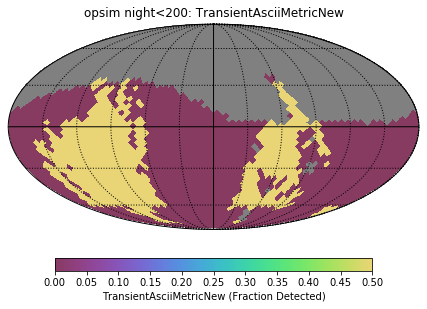

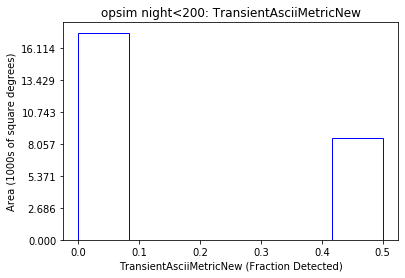

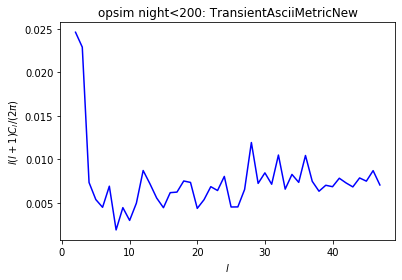

In [4]:
transmetric = TransientAsciiMetricNew('tde.dat', surveyDuration=1, mjdCol='observationStartMJD', detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                                      nPreT=1, preT=10, nFilters=0, filterT=None, nPerLC=2, peakOffset=0, dataout=False)
slicer = slicers.HealpixSlicer(nside=16) 
#year = 1
#sqlconstraint = 'night between %d and %d' % (365.25 * year, 365.25 * (year + 1))
sqlconstraint = 'night<200'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky},opsdb,outDir=outDir,resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

## pull light curve

In [33]:
# get light curve of a pointSlicer

transmetric = TransientAsciiMetricNew('tde.dat', surveyDuration=1, mjdCol='observationStartMJD', detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                                      nPreT=1, preT=10, nFilters=0, filterT=None, nPerLC=2, peakOffset=0, dataout=True)

#ra = np.array([ 34.39339593,  73.58279239,  97.45622484,  94.92638699])
#dec = np.array([ -5.09032894,   0.1873572 , -37.70921729, -18.53667436])
ra = np.array([34.39339593])
dec = np.array([-5.09032894])

slicer = slicers.UserPointsSlicer(ra, dec)

#slicer = slicers.HealpixSlicer(nside=32) 

year = 1
sqlconstraint = 'night between %d and %d' % (365.25 * year, 365.25 * (year + 1))
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky},opsdb,outDir=outDir,resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

Querying database SummaryAllProps with constraint night between 365 and 730 for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter']
Found 225637 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night between 365 and 730" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


In [34]:
data = transmetricSky.metricValues.data[0]

In [35]:
data.keys()

dict_keys(['lcNumber', 'expMJD', 'epoch', 'filter', 'lcMag', 'SNR', 'detected'])

In [36]:
df = pd.DataFrame(data)

In [70]:
df.head(5)

,SNR,detected,epoch,expMJD,filter,lcMag,lcNumber
0,3.195455e+09,False,0.000000,60221.236157,y,0.000000,0.0
1,4.340574e+02,False,1.992303,60223.228461,r,19.059354,0.0
2,4.342279e+02,False,1.992720,60223.228877,r,19.059325,0.0
3,4.343986e+02,False,1.993137,60223.229294,r,19.059296,0.0
4,4.345694e+02,False,1.993553,60223.229711,r,19.059268,0.0


In [43]:
df_0 = df[df['lcNumber']==0.0]
df_1 = df[df['lcNumber']==1.0]

In [67]:
df_0_ = df_0[df_0['lcMag']!=0.0]
df_1_ = df_1[df_1['lcMag']!=0.0]

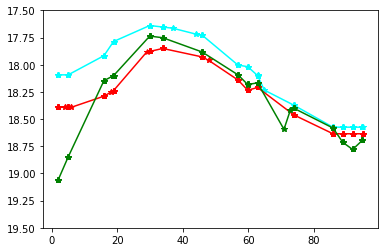

In [68]:
filters = np.unique(df_0_['filter'])
colors = {'u': 'k', 'g': 'cyan', 'r': 'g', 'i': 'r', 'z': 'y', 'y': 'orange'}

for fi in filters:
    time = df_0_['epoch'][df_0_['filter']==fi]
    mag = df_0_['lcMag'][df_0_['filter']==fi]
    
    plt.plot(time, mag, color=colors[fi], marker = '*')
    
    plt.ylim([19.5, 17.5])
    
    

## Importance Rankings

- Image quality
- Sky brightness
- Individual image depth
- Coadded image depth
- Number of exposures in a visit
- Number of visits (in a night)
- Total number of visits 
- Time between visits (in a night)
- Long-term gaps between visits

In [31]:
class ImportanceTestMetric(metrics.BaseMetric):
    """
    returns required data 
    """
    
    def __init__(self, colname=['seeingFwhmEff', 'skyBrightness', 'fiveSigmaDepth', 'numExposures'], **kwargs):
        self.colname = colname
        self.seeingFwhmEff = colname[0]
        self.skyBrightness = colname[1]
        self.fiveSigmaDepth = colname[2]
        self.numExposures = colname[3]
        
        super().__init__(col=colname, metricDtype='float', **kwargs)
        
        
    def run(self, dataSlice, slicePoint=None):
        
        # image quality
        image_quality = np.mean(dataSlice[self.seeingFwhmEff])
        
        # sky brightness
        sky_brightness = np.mean(dataSlice[self.skyBrightness])
        
        # individual image depth
        image_depth = np.mean(dataSlice[self.fiveSigmaDepth])
        
        # coadded image depth
        
        
        # number of exposures in a visit
        num_exposures = np.mean(dataSlice[self.numExposures])
        
        # return importance weitght grade
        result = image_quality + sky_brightness + image_depth + num_exposures
        
        return float(result)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<20 for columns ['fieldRA', 'skyBrightness', 'numExposures', 'fieldDec', 'fiveSigmaDepth', 'seeingFwhmEff']
Found 15051 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<20" constraint now.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/hom

monopole: 43.6242  dipole: lon: 1.10015, lat: 10.1304, amp: 1.23244
Plotting complete.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


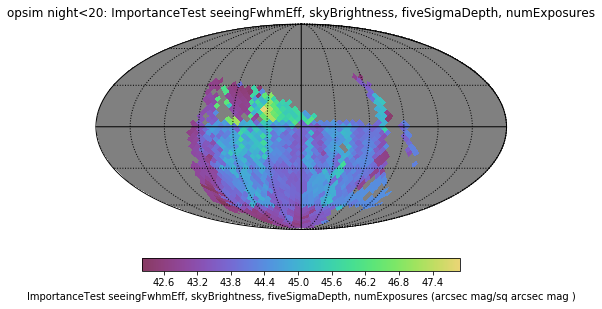

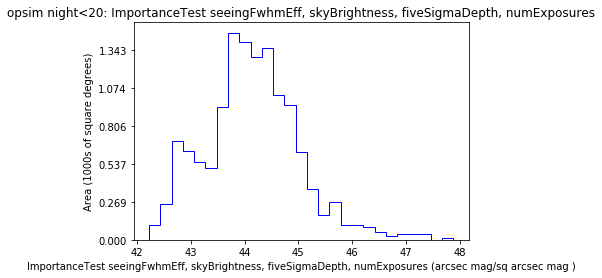

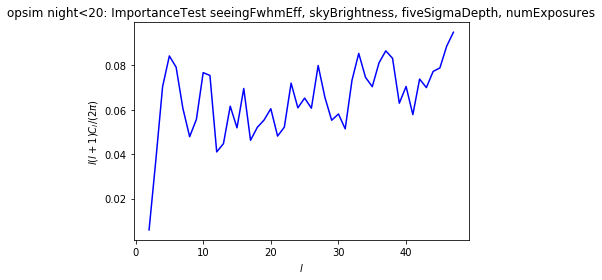

In [32]:
metric = ImportanceTestMetric()
#slicer = slicers.UniSlicer()
slicer = slicers.HealpixSlicer(nside=16)
sqlconstraint = 'night<20'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)
